In [1]:
import pennylane as qml
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCN
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import scatter
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

In [2]:
ds = TUDataset("./data/PROTEINS", "PROTEINS")
ds.num_features, ds.num_classes, len(ds)

(3, 2, 1113)

In [8]:
def build_qfe_circuit(dev, n_qubits, n_layers):
    @qml.qnode(dev, interface="torch") #, diff_method="parameter-shift")
    def qfe_circuit(inputs, weights):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)] #qml.probs(wires=range(n_qubits)) #qml.state() #[qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    
    weight_shapes = {"weights": (n_layers, n_qubits, 3)}
    return qml.qnn.TorchLayer(qfe_circuit, weight_shapes)

class QFE(torch.nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.wires = in_features
        self.dev = qml.device("default.qubit", wires=self.wires)
        self.qfe = build_qfe_circuit(self.dev, self.wires, 2)
    
    def forward(self, x):
        return self.qfe(x)

In [11]:
class QFE_GCN(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.qfe = QFE(in_features)
        # self.lin = torch.nn.Linear(in_features, in_features)

        self.gcn = GCN(
            in_channels=in_features,
            hidden_channels=64,
            num_layers=4,
            dropout = 0.1,
            out_channels=out_features
        )
    
    def forward(self, data):
        x = data.x
        # x = self.lin(x)
        x = self.qfe(x.to(device="cpu")).to(device=x.device)

        x = self.gcn(x, data.edge_index, batch=data.batch)
        
        # x = global_mean_pool(x, data.batch)
        x = scatter(x, data.batch, dim=0, reduce="mean")
        x = F.log_softmax(x, dim=1)

        # out = torch.zeros(data.num_graphs, 2, device=x.device)

        # for i in range(data.num_graphs):
        #     out[i] = x[data.batch == i].mean(dim=0)
        
        # out = F.log_softmax(out, dim=1)
        # x = out
        
        return x

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Need to measure model performance varience.
performance = []
for i in range(10):
    print(f"Model {i}")

    ds = ds.shuffle()
    break1 = int(len(ds) * 0.8)
    break2 = int(len(ds) * 0.9)
    training_data = ds[:break1]
    validation_data = ds[break1:break2]
    test_data = ds[break2:]
    training_loader = DataLoader(training_data, batch_size=2048, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

    model = QFE_GCN(3, 2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in tqdm(range(60)):
        for batch in training_loader:
            optimizer.zero_grad()
            out = model(batch.to(device))
            loss = F.cross_entropy(out, batch.y)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    for batch in test_loader:
        out = model(batch.to(device))
        print()
        correct += sum(out.argmax(dim=1) == batch.y)
        total += len(batch.y)
    print(f"Accuracy: {correct/total}\n")
    performance.append((correct/total).detach().cpu())

Model 0


  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:07<00:00,  8.37it/s]



Accuracy: 0.660714328289032

Model 1


100%|██████████| 60/60 [00:06<00:00,  8.59it/s]



Accuracy: 0.723214328289032

Model 2


100%|██████████| 60/60 [00:07<00:00,  8.50it/s]



Accuracy: 0.6875000596046448

Model 3


100%|██████████| 60/60 [00:06<00:00,  8.84it/s]



Accuracy: 0.6517857313156128

Model 4


100%|██████████| 60/60 [00:06<00:00,  8.59it/s]



Accuracy: 0.7321428656578064

Model 5


100%|██████████| 60/60 [00:07<00:00,  8.49it/s]



Accuracy: 0.723214328289032

Model 6


100%|██████████| 60/60 [00:07<00:00,  8.20it/s]



Accuracy: 0.660714328289032

Model 7


100%|██████████| 60/60 [00:07<00:00,  8.44it/s]



Accuracy: 0.723214328289032

Model 8


100%|██████████| 60/60 [00:07<00:00,  8.44it/s]



Accuracy: 0.7321428656578064

Model 9


100%|██████████| 60/60 [00:06<00:00,  8.57it/s]


Accuracy: 0.6785714626312256



(array([1., 2., 0., 1., 1., 0., 0., 0., 3., 2.]),
 array([0.65178573, 0.65982145, 0.66785717, 0.67589289, 0.68392861,
        0.69196427, 0.69999999, 0.70803571, 0.71607143, 0.72410715,
        0.73214287]),
 <BarContainer object of 10 artists>)

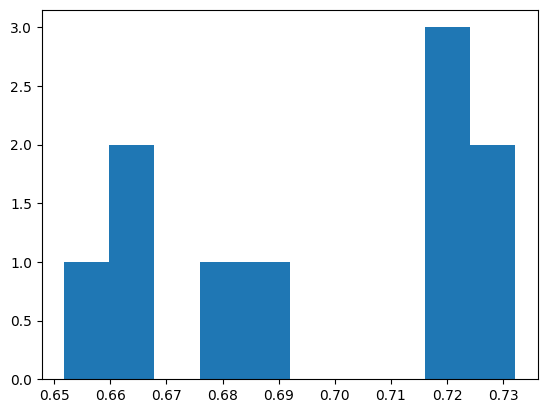

In [13]:
plt.hist(performance)

In [14]:
res = bootstrap((performance,), np.mean, confidence_level=0.95)
m = (res.confidence_interval.low + res.confidence_interval.high)/2
e = (res.confidence_interval.high - res.confidence_interval.low)/2
print(f"{m} plus.minus {e}")

0.6973214149475098 plus.minus 0.018750011920928955


<BarContainer object of 4 artists>

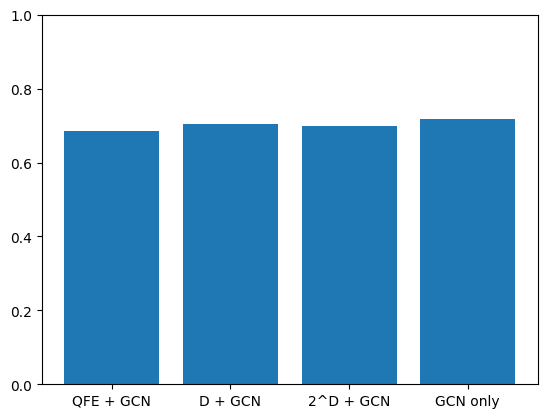

In [52]:
a = [0.684375017881393,0.704910725355148,0.697785774177378,0.717857182025909]
b = ["QFE + GCN", "D + GCN", "2^D + GCN", "GCN only"]
plt.ylim(0, 1)
plt.bar(b, a)
